In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In /home/hep/mhh18/.config/matplotlib/stylelib/cms-img.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/hep/mhh18/.config/matplotlib/stylelib/cms-img.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/hep/mhh18/.config/matplotlib/stylelib/cms-img.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/hep/mhh18/.config/matplotlib/stylelib/cms.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/hep/mhh18/.config/matplotlib/stylelib/cms.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.

In [2]:
sys.path.insert(0, '..') #add paernet directory to the list in which packages are searched

In [3]:
from funcs import getParMtxPerBundle, getModulesPerBundle

Welcome to JupyROOT 6.22/06


In [4]:
with open('../input/allocation/allocation_20200729_1.txt') as f:
    lines = [line.rstrip('\n') for line in f]
f.close()

In [5]:
bundles = getModulesPerBundle(lines)

In [6]:
parMtxEM_PerBundle, parMtxHad_PerBundle = getParMtxPerBundle(bundles, '../output/tower_module_mapping_array/', 'param_mtx_em.pkl', 'param_mtx_had.pkl')

In [7]:
indicesEM = [idx[3:] for idx in parMtxEM_PerBundle[0].index]
indicesHad = [idx[4:] for idx in parMtxHad_PerBundle[0].index]

In [8]:
#indices = indicesEM + list(set(indicesHad) - set(indicesEM))

In [138]:
def make_df(parMtx_PerBundle, indices, isHad): #isHad is True for CE-H and False otherwise
    name = 'Had' if isHad else 'EM'
    cutIndex = 4 if isHad else 3
    df = pd.DataFrame({name:np.zeros(len(indices))}, index = indices).astype(int)
    for bundle in parMtx_PerBundle: #0,1,...,23
        towers = [tower[cutIndex:] for tower in \
                  parMtx_PerBundle[bundle][(parMtx_PerBundle[bundle] != 0).any(axis=1)].index]
        df.loc[df.index.isin(towers), name] += 1
    return df

def find_eta(name):
    return int(name[name.find('eta')+3 : name.find('-phi')])

def find_phi(name):
    return int(name[name.find('-phi')+4:])

def remove_phi(name):
    return name[:name.find('-phi')+4]

def plotHist(data, Name):
    data=data[data!=0]
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }
    title = 'CE-E' if data.name=='EM' else 'CE-H'
    print('mean = ', round(data.mean(), 2))
    print('maximum = ', data.max())
    print('total entries = ', len(data))
    binwidth = 1
    bins=np.arange(1, max(data) + 2*binwidth, binwidth)
    plt.hist(data, bins, ec='black')
    plt.xticks(bins[::2])
    plt.xlabel('number of Stage 1 FPGAs sending tower')
    plt.ylabel('number of towers')
    plt.title(title)
    plt.savefig('numOfStage1FPGAsSendingTower_' + Name + '.pdf')
    
def divideByRepeat(df):
    df_countedOnce = df.copy()
    countedTwice = {}
    for tower in df.index:
        if (find_phi(tower) < 0) | (find_phi(tower) > 23):
            if(remove_phi(tower) + str(find_phi(tower) % 24) in df.index):
                nameMerged = remove_phi(tower)+str(find_phi(tower))+'/'+str(find_phi(tower) % 24)
                name1 = tower
                name2 = remove_phi(tower)+str(find_phi(tower) % 24)
                countedTwice[nameMerged] = int(df.loc[name1] + df.loc[name2])
                df_countedOnce = df_countedOnce.drop([name1, name2])
    df_countedTwice = pd.DataFrame(pd.Series(countedTwice), columns = df.columns)
    return df_countedOnce, df_countedTwice
    
def divideBy30deg(df):
    under30 = {}
    above30 = {}
    for tower in df.index:
        if int(find_phi(tower))<6:
            under30[tower] = int(df.loc[tower])
        else:
            above30[tower] = int(df.loc[tower])
    df_under30 = pd.DataFrame(pd.Series(under30), columns = df.columns)
    df_above30 = pd.DataFrame(pd.Series(above30), columns = df.columns)
    
    return df_under30, df_above30

In [10]:
df_EM = make_df(parMtxEM_PerBundle, indicesEM, isHad = False)
df_Had = make_df(parMtxHad_PerBundle, indicesHad, isHad = True)

In [94]:
df_countedOnceEM, df_countedTwiceEM = divideByRepeat(df_EM)

In [95]:
df_countedOnceHad, df_countedTwiceHad = divideByRepeat(df_Had)

In [96]:
df_countedOnceEM_under30, df_countedOnceEM_above30 = divideBy30deg(df_countedOnceEM)

In [97]:
df_countedOnceHad_under30, df_countedOnceHad_above30 = divideBy30deg(df_countedOnceHad)

mean =  10.84
maximum =  19
total entries =  122


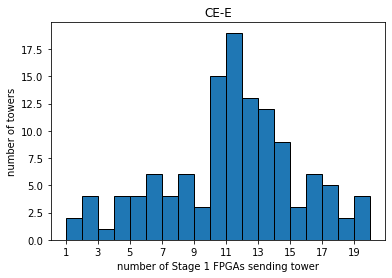

In [139]:
plotHist(df_countedOnceEM_under30['EM'], 'countedOnceEM_under30')

mean =  11.37
maximum =  20
total entries =  286


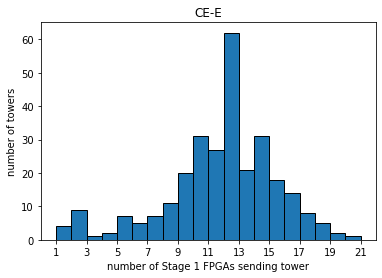

In [140]:
plotHist(df_countedOnceEM_above30['EM'], 'countedOnceEM_above30')

mean =  16.5
maximum =  22
total entries =  10


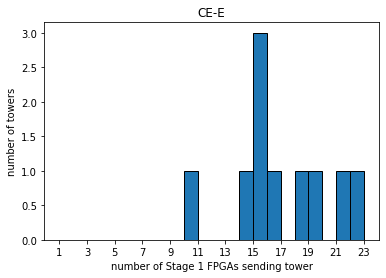

In [141]:
plotHist(df_countedTwiceEM['EM'], 'df_countedTwiceEM')

mean =  11.4
maximum =  17
total entries =  90


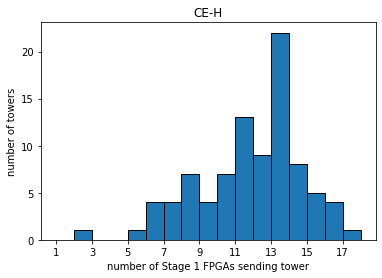

In [142]:
plotHist(df_countedOnceHad_under30['Had'], 'countedOnceHad_under30')

mean =  10.84
maximum =  17
total entries =  307


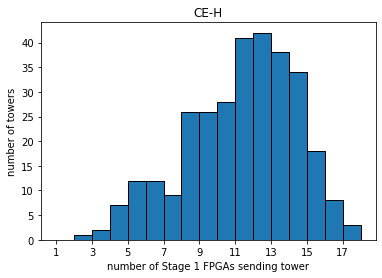

In [143]:
plotHist(df_countedOnceHad_above30['Had'], 'countedOnceHad_above30')

mean =  12.51
maximum =  18
total entries =  35


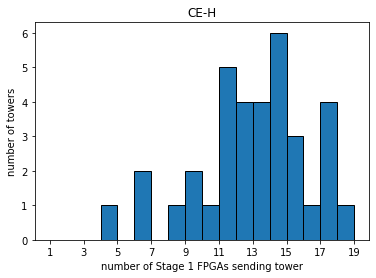

In [144]:
plotHist(df_countedTwiceHad['Had'], 'df_countedTwiceHad')